<img src="volatility.jpg" width="500" height="300" align="right"/>

# Time Series Analysis: G_ARCH Models

Author: Christoph Güttner


**Abstract**  
An ARCH(3) and a GARCH(2,2) (Generalised Auto Regressive   
with Conditional Heteroscedasticity) process are generated,  
analysed (autocorrelation and stationarity) and predictions  
about their volatility are derived. Therefore daily data  
of three years (2018-2021) is used to train the respective model  
and predict two further months (-March,1,2021).

In general, an **ARCH(p)** process $y_t$ is described as follows:

$y_t = \epsilon_t * \sigma_t$  with $\epsilon= \mathcal{N}(\mu, \sigma^2)$
  
$\sigma^{2}_{t} =a_0 + \sum_{i=1}^{p} a_i y^2_{t-i}$  

A **GARCH(p,q)** process is described as follows:

$y_t = \epsilon_t * \sigma_t$  
  
$\sigma^{2}_{t} = a_0 + \sum_{i=1}^{p} a_i y^2_{t-i}+ b_0 +\sum_{j=1}^{q} b_j \sigma^2_{t-j} $  

where $\sigma^2$ describes the volatility of a stationary  
time series $y_t$ with mean $\mu=0$


## Table of Contents
* [Loading and Preprocessing](#Loading_and_Preprocessing)
    * [Imports](#Imports)
    * [Functions](#Functions)

* [Time Series Generation](#Time_Series_Generation)
    * [ARCH(2) Process](#ARCH(2)_Process
    * [GARCH(2,2) Process](#GARCH(2,2) Process)
      
* [Partial-Autocorrelation](#Partial_Autocorrelation)
* [Dickey Fuller Test](#Dickey_Fuller_Test)
* [Models and Forecasts](#Models_and_Forecasts)
* [Rolling Forcast](#Rolling_Forcast)

    * [ARCH(3) Volatility Prediction](#ARCH(3) Volatility_Prediction)
    * [GARCH(2,2) VolatilityPrediction](#GARCH(2,2) Volatility_Prediction)



### Imports

In [41]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from arch import arch_model



### Functions

In [42]:

def generate_ARCH(p,a,c, n_samples):
    y = [np.random.normal(0,1)]*p
    sigma = []

    for t in range(n_samples):
        sum = 0.0
        for i in range(1,p+1):
            sum += a[i-1] * y[t-i]**2

        new_vol = np.sqrt(c + sum)
        new_val = np.random.normal(0,1) * new_vol

        y.append(new_val)
        sigma.append(new_vol)

    return y[p:], sigma


def generate_GARCH(p,q,a,b, c, n_samples):
    y = [np.random.normal(0,1)]*p
    sigma = [1]*q

    for t in range(n_samples):
        sum = 0.0
        for i in range(1,p+1):
            sum += a[i-1] * y[t-i]**2
        for j in range(1,q+1):
            sum += b[j-1] * sigma[t-j]**2

        new_vol = np.sqrt(c + sum)
        new_val = np.random.normal(0,1) * new_vol

        y.append(new_val)
        sigma.append(new_vol)

    return y[p:], sigma[q:]

def plot_dataframe(df, title):
    df.plot(figsize=(15,5))
    plt.axvspan('1/1/2021', '3/1/2021', color='k', alpha=0.2)
    plt.axhline(0, linestyle='--', color='grey')
    plt.fill_between(df.index, df['Volatility'], color='orange', alpha=0.2)
    plt.title(title, color='k')
    plt.show()

def dickey_fuller(ts):
    result = adfuller(ts)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if result[0] < result[4]["5%"]:
        print ("Reject Ho - Time Series is Stationary")
    else:
        print ("Failed to Reject Ho - Time Series is Non-Stationary")


def rolling_forecast_arch3(df, train_len, test_len):
    start = df.iloc[:,[1]].values.mean()
    rolling_predictions = [start]
    for i in range(test_len-1):
        train = df.iloc[:(train_len+i), [0]]
        model = arch_model(train, p=3)
        model_fit = model.fit(disp='off')
        pred = model_fit.forecast(horizon=1)
        rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))
    return rolling_predictions

def rolling_forecast_garch22(df, train_len, test_len):
    start = df.iloc[:,[1]].values.mean()
    rolling_predictions = [start]
    for i in range(test_len-1):
        train = df.iloc[:(train_len+i), [0]]
        model = arch_model(train, p=2, q=2)
        model_fit = model.fit(disp='off')
        pred = model_fit.forecast(horizon=1)
        rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))
    return rolling_predictions

## Time_Series_Generation

In [43]:
date_index = pd.date_range(start='1/1/2018', end='3/1/2021')
n_samples = len(date_index)

### ARCH(3)_Process

In [44]:
# create dataset
np.random.seed(3)

c = 0.9 #a0+b0
a = [0.8, 0.4, 0,6]
p=3

ts_a, volat_a = generate_ARCH(p,a, c, n_samples)

In [45]:
data_arch={'ts_arch':ts_a,'Volatility':volat_a}
df_arch = pd.DataFrame(data_arch, index=date_index)
df_arch.head(3)

,ts_arch,Volatility
2018-01-01,0.950252,2.176931
2018-01-02,0.188616,1.954621
2018-01-03,-4.056696,2.176931


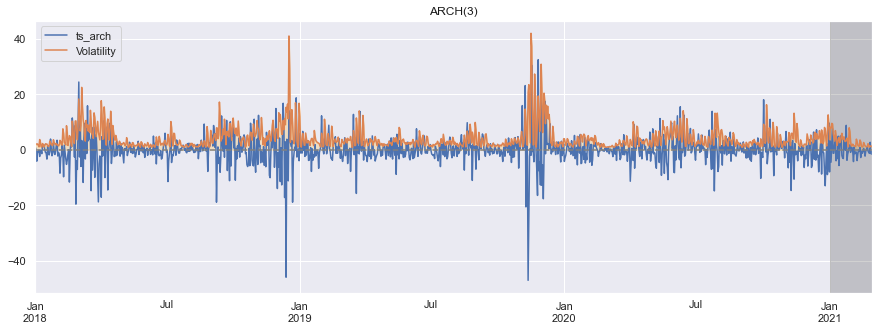

In [46]:
plot_dataframe(df_arch, title='ARCH(3)')

### GARCH(2,2)_Process

In [62]:
# create dataset
np.random.seed(2)
c = 0.5 #a0+b0

a = [0.1, 0.2]
b = [0.3, 0.4]
p=2
q=2

ts_g, volat_g = generate_GARCH(p,q,a,b, c, n_samples)

In [63]:
data_garch={'ts_garch':ts_g,'Volatility':volat_g}
df_garch = pd.DataFrame(data_garch, index=date_index)
df_garch.head(3)

,ts_garch,Volatility
2018-01-01,-0.062961,1.118975
2018-01-02,-2.453376,1.148479
2018-01-03,1.835423,1.118975


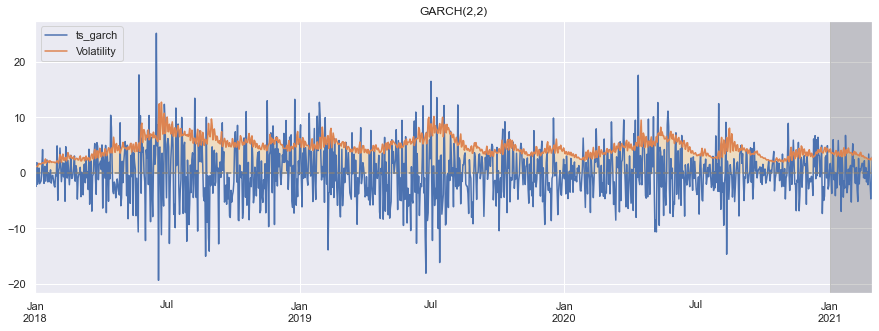

In [64]:
plot_dataframe(df_garch.iloc[:,:], title='GARCH(2,2)')


## Partial_Autocorrelation

### ARCH(3)_Partial_Autocorrelation

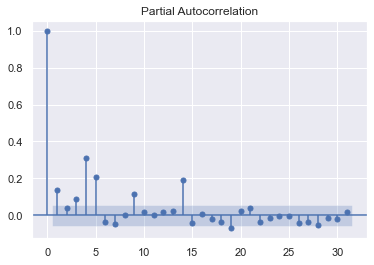

In [50]:
plot_pacf(df_arch['ts_arch']**2)
plt.show()

### GARCH(2,2)_Partial_Autocorrelation

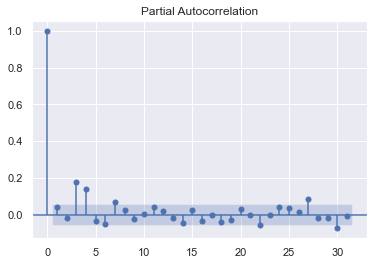

In [51]:
plot_pacf(df_garch['ts_garch']**2)
plt.show()

## Dickey_Fuller_Test

Testing for stationarity 

### For ARCH(3) Process

In [52]:
dickey_fuller(df_arch['ts_arch'])

ADF Statistic: -12.139471
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Reject Ho - Time Series is Stationary


### For GARCH(2,2) Process

In [53]:
dickey_fuller(df_garch['ts_garch'])

ADF Statistic: -21.017543
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Reject Ho - Time Series is Stationary


## Models_and_Forecasts
### Train Test Split

In [54]:
df_train_arch = df_arch['1/1/2018':'1/1/2021']
df_test_arch = df_arch['1/1/2021':'3/1/2021']

df_train_garch = df_garch['1/1/2018':'1/1/2021']
df_test_garch = df_garch['1/1/2021':'3/1/2021']

In [55]:
train_len = len(df_train_arch)
test_len = len(df_test_arch)

## Rolling_Forecast

The test lenth is 60 timesteps. However, the forecasting horizon   
is only one timestep. After each timestep the model is updated and  
a new forecast is made.

### ARCH(3) Volatility_Prediction

In [65]:
rf_arch3 = rolling_forecast_arch3(df_arch, train_len, test_len)

Text(0.5, 1.0, 'ARCH(3) - Volatility Prediction')

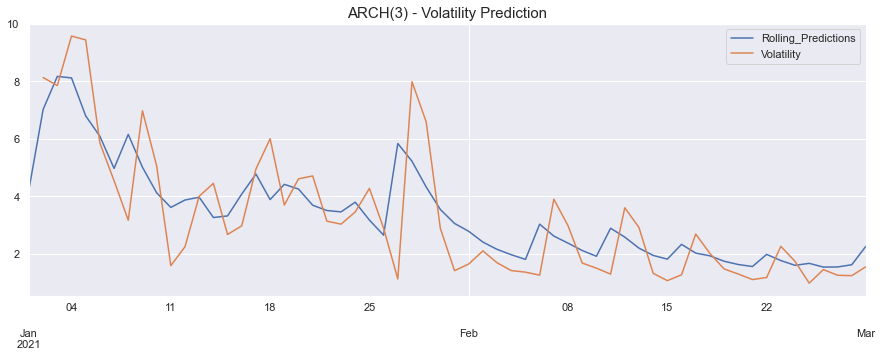

In [70]:
r_predictions_arch = {'Rolling_Predictions':rf_arch3}
df_pred_arch = pd.DataFrame(r_predictions_arch, index=df_test_arch.index)
df_final_arch = df_pred_arch .join(df_arch.iloc[train_len:,[1]])
df_final_arch.plot(figsize=(15,5))
plt.title('ARCH(3) - Volatility Prediction', fontsize=15)

### GARCH(2,2)- Volatility_ Prediction

In [66]:
rf_garch22= rolling_forecast_garch22(df_garch, train_len, test_len)


Text(0.5, 1.0, 'GARCH(2,2) - Volatility Prediction')

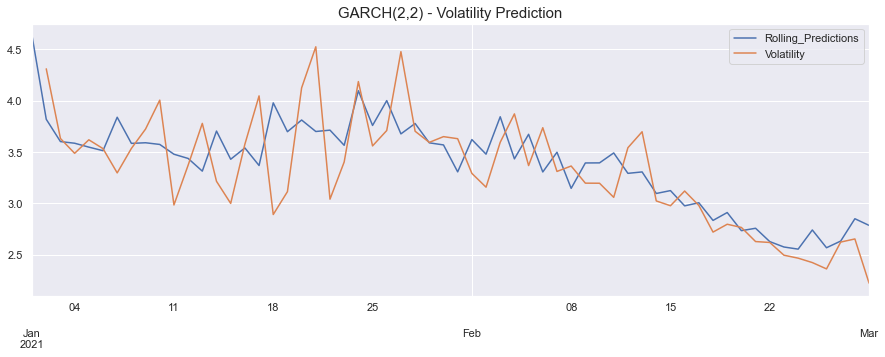

In [69]:
r_predictions_garch = {'Rolling_Predictions':rf_garch22}
df_pred_garch= pd.DataFrame(r_predictions_garch, index=df_test_arch.index)
df_final_garch= df_pred_garch.join(df_garch.iloc[train_len:,[1]])
df_final_garch.plot(figsize=(15,5))
plt.title('GARCH(2,2) - Volatility Prediction', fontsize=15)